## <center> Decision trees for classification and regression

**In this assignment, we will find out how a decision tree works in a regression task, then will build and tune classification decision trees for identifying heart diseases.
Fill in the missing code in the cells marked "You code here" and answer the questions in the [web form](https://docs.google.com/forms/d/1hsrNFSiRsvgB27gMbXfQWpq8yzNhLZxuh_VSzRz7XhI).**

In [236]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import pydotplus
import IPython

## 1. A simple example of regression using decision trees

Let's consider the following one-dimensional regression problem. It is needed to build the function $a(x)$ to approximate original dependency $y = f(x)$ using mean-squared error ${min} \sum_i {(a(x_i) - f(x_i))}^2$.

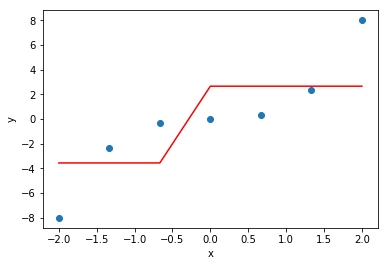

In [237]:
X = np.linspace(-2,2,7)
y = X ** 3
predictions = [np.mean(y[X<0]) if x<0 else np.mean(y[X>=0]) for x in X]
plt.scatter(X,y)
plt.plot(X,predictions,c='red')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Let's make several steps to build the decision tree. Let's choose the symmetric thresholds equal to 0, 1.5 and -1.5 for partitioning. In the case of a regression task, the leaf outputs mean answer for all observations in this leaf.

Let's start from tree of depth 0 that contains all train observations. How will predictions of this tree look like for $x \in [-2, 2]$? Create the appropriate plot using a pen, paper and Python if it is needed (without using `sklearn`).

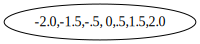

In [238]:
#Predictions would consider the whole range -2 to 2. However, there will only be one node that can only make the intial 
#decision. This lack of depth would not be suitable for predictions.
graph_a = pydotplus.graph_from_dot_file('Resources/0Node.dot')
graph_a.write_svg('Resources/0-Node-Example.svg') # generate graph in svg.
IPython.display.SVG('Resources/0-Node-Example.svg')


<function matplotlib.pyplot.show>

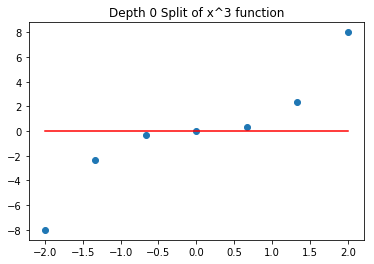

In [239]:
xx = np.linspace(-2,2,100)
predictions = [np.mean(y) for x in xx]
plt.scatter(X,y)
plt.plot(xx,predictions,c='red')
plt.title('Depth 0 Split of x^3 function')
plt.show

Let's split the data according to the following condition $[x < 0]$. It gives us the tree of depth 1 with two leaves. Let's create a similar plot for predictions of this tree.

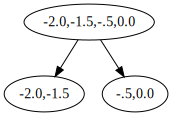

In [240]:
# We would see only one partition of a decision tree where our data lies for points [-2 to 0).

graph_b = pydotplus.graph_from_dot_file('Resources/1Node.dot')
graph_b.write_svg('Resources/1-Node-Example.svg')
IPython.display.SVG('Resources/1-Node-Example.svg')

<function matplotlib.pyplot.show>

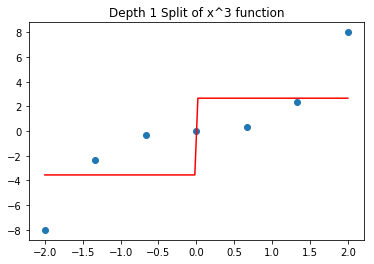

In [241]:
xx = np.linspace(-2,2,100)
predictions = [np.mean(y[X<0]) if x<0 else np.mean(y[X>=0]) for x in xx]
plt.scatter(X,y)
plt.plot(xx,predictions,c='red')
plt.title('Depth 1 Split of x^3 function')
plt.show

In the decision tree algorythm the feature and the threshold for splitting are chosen by some criterion. The commonly used criterion for regression is variance: $$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
where $X$ are observations in this node, $X_l$ and $X_r$ are splits of sample $X$ for two parts by the following criterion $[x_j < t]$ (by $j$-th feature and threshold $t$), $|X|$, $|X_l|$, $|X_r|$ are sizes of approprite samples, and $D(X)$ is the variance of the answers in $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
where $y_i = y(x_i)$ is the answer for $x_i$ observation. Feature $j$ and threshold $t$ are chosen to maximize the value of the functional $Q(X, j, t)$ for each split.

In our case there's only one feature so $Q$ depends on threshold $t$ (and answers in this node).

Create the plot of the function $Q(X, t)$ in the root depending on the threshold value $t$ on the interval $[-1.9, 1.9]$.

In [242]:
#Criterion for splitting in decision tree algorithm is Q(X,j,t) = D(X)-|X_t|/|X|D(X_l)-|X_r|/|X|D(X_r)
#X_t & X_r are splits of sample X for two parts of x_j < t

In [243]:
print(f"X values: {X}",f"y values: {y}")

SyntaxError: invalid syntax (<ipython-input-243-06c9edd7e392>, line 1)

In [244]:
#We have one feature, so j=1. Threshold t is greater than x_1.
def regression_var_criterion(X, y, t):
    def D_variances(X_val,y_val): 
        X_norm = np.linalg.norm(X_val)
        return (1/X_norm) * np.sum( (y_val - ((1/X_norm)* np.sum(y_val) ))**2 )    
    X_l, X_r = X[X<t], X[X>=t]
    y_l, y_r = y[X<t], y[X>=t]
    X_norm = np.linalg.norm(X)
    X_l_norm = np.linalg.norm(X_l)
    X_r_norm = np.linalg.norm(X_r)
    D_l = D_variances(X_l,y_l)
    D_r = D_variances(X_r,y_r)
    D = D_variances(X,y)
    l_calculation = (X_l_norm/X_norm) * D_l
    r_calculation = (X_r_norm/X_norm) * D_r
    Q = D - l_calculation - r_calculation  
    return Q

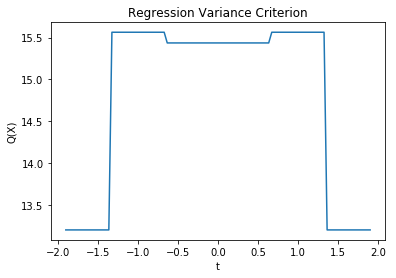

In [245]:
ticks = np.linspace(-1.9, 1.9, 100)
criterion = [regression_var_criterion(X,y,tick) for tick in ticks]
plt.plot(ticks,criterion)
plt.title('Regression Variance Criterion')
plt.xlabel('t')
plt.ylabel('Q(X)')
plt.show()

**<font color='red'>Question 1.</font> Is the threshold value $t = 0$ optimal according to the variance criterion?**
- Yes
- No 

Ans:
Threshold value t=0 is **not** optimal according to variance criterion.

____

Then let's make splitting in each of the leaves' nodes. In the left branch (where previous split was $x < 0$) using the criterion $[x < -1.5]$, in the right branch (where previous split was $x \geqslant 0$) with the following criterion $[x < 1.5]$. It gives us the tree of depth 2 with 7 nodes and 4 leaves. Create the plot of these tree predictions for $x \in [-2, 2]$.

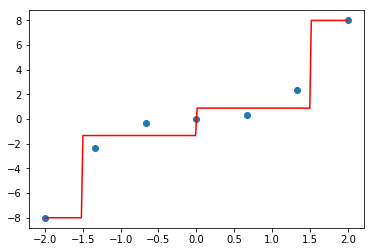

In [246]:
x_space = np.linspace(-2,2,200)
def prediction(X,y,x):
    if x>=1.5:
        return np.mean(y[X>=1.5])
    elif x<1.5 and x>=0:
        return np.mean(y[(X>=0) & (X<1.5)])
    elif x>=-1.5 and x<0:
        return np.mean(y[(X>=-1.5) * (X<0)])
    else:
        return np.mean(y[X<-1.5])
predictions = [prediction(X,y,x_element) for x_element in x_space]
plt.scatter(X,y)
plt.plot(x_space,predictions,c='red')

**<font color='red'>Question 2.</font> How many segments are there on the plot of tree predictions in the interval [-2, 2] (it is necessary to count only horizontal and lines)?**
- 2
- 3
- 4
- 5

Ans:

Based on the number of partitions we did, 4.

## 2. Building a decision tree for predicting heart deseases

**Problem**

Predict presence or absence of cardiovascular disease (CVD) using the patient examination results.

**Data description**

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

In [247]:
df = pd.read_csv('Resources/mlbootcamp5_train.csv', sep=';')

In [248]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [249]:
df['cholesterol'].value_counts()

1    52385
2     9549
3     8066
Name: cholesterol, dtype: int64

Transform the features: create "age in years" (full age) and also create 3 binary features based on `cholesterol` and 3 more on `gluc`, where they are equal to 1, 2 or 3. This method is called dummy-encoding or One Hot Encoding (OHE). It is more convenient to use `pandas.get_dummmies.`. There is no need to use the original features `cholesterol` and `gluc` after encoding.

In [250]:
df['age_in_years'] = (df['age']/365).astype(int)

In [251]:
#One Hot Encoding, Dummy Variable encoding
pd = pd.get_dummies(df,columns=['cholesterol','gluc'])

In [252]:
target = df.cardio

In [253]:
training_data = df.drop(['cardio','id'], axis=1)

Split data into train and holdout parts in the proportion of 7/3 using `sklearn.model_selection.train_test_split` with `random_state=17`.

In [254]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training_data, target,random_state=17,test_size =.3)

Train the decision tree on the dataset `(X_train, y_train)` with max depth equals to 3 and `random_state=17`. Plot this tree with `sklearn.tree.export_graphviz`, `dot` and `pydot`. You don't need to use quotes in the file names in order to make it work in a jupyter notebook. The commands starting from the exclamation mark are terminal commands that are usually run in terminal/command line.

In [255]:
#from sklearn.tree import DecisionTreeClassifier, export_graphviz
model = DecisionTreeClassifier(max_depth =3, random_state=17)

In [256]:
model.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [267]:
from ipywidgets import Image
from io import BytesIO as StringIO
import pydotplus

dot_data = StringIO()
export_graphviz(model, feature_names=training_data.columns, 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(value=graph.create_png())


SW1hZ2UodmFsdWU9J1x4ODlQTkdcclxuXHgxYVxuXHgwMFx4MDBceDAwXHJJSERSXHgwMFx4MDBceDA2XHgxNlx4MDBceDAwXHgwMVx4ZGRceDA4XHgwNlx4MDBceDAwXHgwMFx4ZjFZQ1x4YmLigKY=


**<font color='red'>Question 3.</font> What 3 features are used to make predictions in the created decision tree?**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

Make predictions for holdout data `(X_valid, y_valid)` with the trained decision tree. Calculate accuracy.

In [268]:
predicted_values = model.predict(X_test)

In [302]:
regular_model_accuracy_score = accuracy_score(y_test,predicted_values)
regular_model_accuracy_score

0.72128571428571431

Set up the depth of the tree using cross-validation on the dataset `(X_train, y_train)` in order to increase quality of the model. Use `GridSearchCV` with 5 folds. Fix `random_state=17` and change  `max_depth` from 2 to 10.

In [283]:
from sklearn.model_selection import GridSearchCV

tree_params = {'max_depth': list(range(2,11))}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17),
                         tree_params,cv=5,scoring='accuracy')
tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Draw the plot to show how mean accuracy is changing in regards to `max_depth` value on cross-validation.

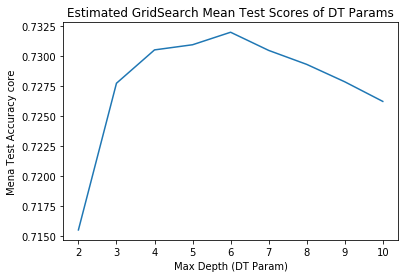

In [294]:
plt.plot(tree_params['max_depth'] , tree_grid.cv_results_['mean_test_score'])
plt.title('Estimated GridSearch Mean Test Scores of DT Params')
plt.xlabel('Max Depth (DT Param)')
plt.ylabel('Mena Test Accuracy core')
plt.show()

Print the best value of `max_depth` where the mean value of cross-validation quality metric reachs maximum. Also compute accuracy on holdout data. All these computations are possible to make using the trained instance of the class `GridSearchCV`.

In [295]:
print("Best params:", tree_grid.best_params_)
print("Best cross validaton score", tree_grid.best_score_)

('Best params:', {'max_depth': 6})
('Best cross validaton score', 0.73195918367346935)


In [301]:
tree_grid_accuracy_score = accuracy_score(y_test, tree_grid.predict(X_test))
print('Accuracy of Best model to holdout data:', tree_grid_accuracy_score)

('Accuracy of Best model to holdout data:', 0.72585714285714287)


In [303]:
(tree_grid_accuracy_score - regular_model_accuracy_score)/regular_model_accuracy_score * 100

0.63378886908298504

**<font color='red'>Question 4.</font> Is there a local maximum of accuracy on the built validation curve? Did `GridSearchCV` help to tune `max_depth` so that there's been at least 1% change in holdout accuracy?**
(check out the expression (acc2 - acc1) / acc1 * 100%, where acc1 and acc2 are accuracies on holdout data before and after tuning `max_depth` with `GridSearchCV` respectively)?

- yes, no 